<a href="https://colab.research.google.com/github/rachitch11/US-Houses-Price-Prediction-Model/blob/main/myassignment_Home_Price_Model_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 US Home Price Analysis (2005-2025)
This notebook models how key economic factors influenced the S&P Case-Shiller Home Price Index over the last 20 years.

In [2]:
 pip install pandas matplotlib seaborn scikit-learn statsmodels fredapi

In [66]:
# 🐍 Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from fredapi import Fred

In [67]:
# 🔑 Step 3: Set FRED API Key (Replace with your key)
fred = Fred(api_key='bbee76c5ee8ac594dd4d91c993369086')

In [68]:
# 📥 Step 4: Download Data from FRED (Expanded Set)
home_price = fred.get_series('CSUSHPISA').rename("HomePrice")
gdp_growth = fred.get_series('GDPC1').rename("GDPGrowth")
mortgage_rate = fred.get_series('MORTGAGE30US').rename("MortgageRate")
unemployment = fred.get_series('UNRATE').rename("Unemployment")
inflation = fred.get_series('CPIAUCSL').rename("CPI")
housing_starts = fred.get_series('HOUST').rename("HousingStarts")

# Additional Factors
income = fred.get_series('DSPIC96').rename("PersonalIncome")         # Real disposable personal income
population = fred.get_series('POP').rename("Population")             # U.S. population
construction_spending = fred.get_series('TLRESCONS').rename("ConstructionSpending")  # Residential construction spending
median_rent = fred.get_series('CUUR0000SEHA').rename("MedianRent")   # CPI for Rent
homeownership_rate = fred.get_series('RHORUSQ156N').rename("HomeownershipRate")  # % of households owning homes

In [69]:
# 🧹 Step 5: Resample to Monthly Frequency & Clean Data

# Resample all data to monthly frequency
home_price = home_price.resample('ME').mean()
gdp_growth = gdp_growth.resample('ME').ffill()
mortgage_rate = mortgage_rate.resample('ME').mean()
unemployment = unemployment.resample('ME').mean()
inflation = inflation.resample('ME').mean()
housing_starts = housing_starts.resample('ME').mean()

income = income.resample('ME').ffill()  # Personal income: forward fill
population = population.resample('ME').ffill()  # Population: forward fill
construction_spending = construction_spending.resample('ME').mean()
median_rent = median_rent.resample('ME').mean()
homeownership_rate = homeownership_rate.resample('ME').ffill()  # Homeownership rate: quarterly, so ffill

# Combine all data into a single DataFrame
data = pd.concat([
    home_price,
    gdp_growth,
    mortgage_rate,
    unemployment,
    inflation,
    housing_starts,
    income,
    population,
    construction_spending,
    median_rent,
    homeownership_rate
], axis=1)

# Drop missing values and filter for years 2005 onwards
data.dropna(inplace=True)
data = data.loc["2005-01-01":]

# Preview the dataset
print("Final dataset shape:", data.shape)
data.head()
data.tail()


Final dataset shape: (241, 11)


,HomePrice,GDPGrowth,MortgageRate,Unemployment,CPI,HousingStarts,PersonalIncome,Population,ConstructionSpending,MedianRent,HomeownershipRate
2024-09-30,323.282,23400.294,6.180,4.1,314.851,1357.0,17519.6,340734.171,903941.0,423.821,65.6
2024-10-31,324.466,23542.349,6.428,4.1,315.564,1352.0,17586.3,340916.485,934237.0,425.381,65.7
2024-11-30,326.006,23542.349,6.805,4.2,316.449,1295.0,17618.0,341088.462,936848.0,426.651,65.7
2024-12-31,327.680,23542.349,6.715,4.1,317.603,1514.0,17638.6,341249.828,939666.0,428.151,65.7
2025-01-31,329.481,23528.047,6.958,4.0,319.086,1358.0,17655.7,341390.432,941441.0,429.506,65.1


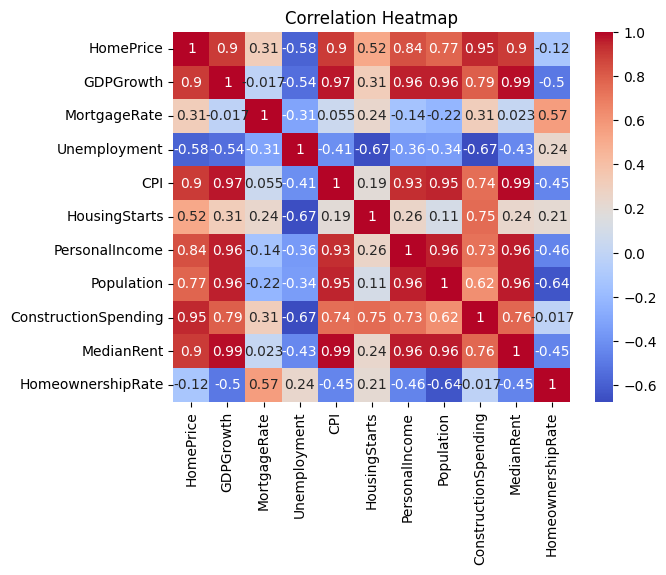

In [70]:
# 📊 Step 6: Exploratory Data Analysis
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [71]:
# 🧮 Step 7: Feature Engineering - Percent Change
data_pct = data.pct_change().dropna()
data_pct.head()

,HomePrice,GDPGrowth,MortgageRate,Unemployment,CPI,HousingStarts,PersonalIncome,Population,ConstructionSpending,MedianRent,HomeownershipRate
2005-02-28,0.012754,0.000000,-0.014448,0.018868,0.004175,0.029384,0.000223,0.000648,0.022085,0.002331,0.000000
2005-03-31,0.015109,0.000000,0.053398,-0.037037,0.003638,-0.155415,0.003544,0.000617,0.005382,0.002326,0.000000
2005-04-30,0.010186,0.004926,-0.012314,0.000000,0.003107,0.105687,0.003141,0.000687,0.011345,0.002320,-0.007236
2005-05-31,0.011039,0.000000,-0.023057,-0.019231,-0.000516,-0.017467,0.004290,0.000724,0.008601,0.001852,0.000000
2005-06-30,0.010865,0.000000,-0.024126,-0.019608,0.000517,0.021235,0.002008,0.000785,0.022253,0.001848,0.000000


In [72]:
# 🤖 Step 8: Prepare Data for Modeling
X = data_pct.drop('HomePrice', axis=1)
y = data_pct['HomePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [73]:
# 🧠 Step 9: Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [74]:
# 📈 Step 10: Evaluate Model
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score: 0.12003471053718007
Mean Squared Error: 3.877675696639635e-05


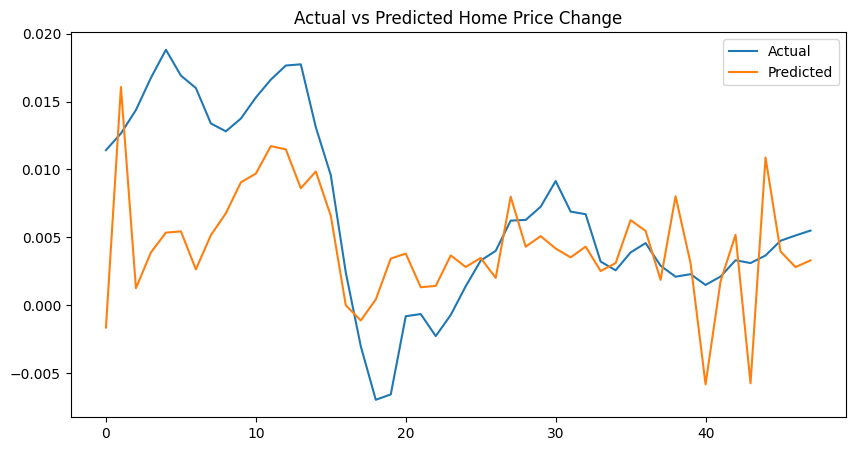

In [75]:
# 📉 Step 11: Visualize Predictions vs Actual
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted Home Price Change")
plt.legend()
plt.show()